# EECS 504 (Computer Vision) Project
**Brain Tumor Segmentation using 3D U-Net**

Authors:

1.   Shrikant Arvavasu (ashri@umich.edu)
2.   Sachin Salim (sachinks@umich.edu)
3.   Nowrin Mohamed (nowrin@umich.edu)

# Initializing

## Import Libraries

In [1]:
###Libraries and imports
import numpy as np
import math
import random
import os
import shutil
import gzip
import glob
import gc
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tarfile
import PIL
import scipy.misc
import skimage
import nibabel as nib
import pdb
from matplotlib.patches import Rectangle
import pickle
from skimage.metrics import hausdorff_distance

from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers 
from keras import backend as K
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from skimage.io import imread
from scipy import ndimage as ndi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers
from skimage.morphology import binary_closing

## Mount Google Drive

In [2]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)


Mounted at /content/drive/


## Global variables

In [3]:
# mention root directory here
ROOT_DIR = f'{drive_mount_point}MyDrive/bts_data'

NUM_EPOCHS = 10

# count of data used
DATA_COUNT = {'train': 285, 'validation': 66, 'test': 191}

# key of the model (1, 2, 3)
MODEL_KEY = 'model_1'

INPUT_SIZE = 64 #N

ENCODING_BLOCKS = 3 #M

NO_OF_FILTERS = 64 #F


'''N: shape of input image, same as shape of output
    M: number of encoding/decoding blocks
    F: number of filters in the initial block'''

# Parameters
PARAMS = {'orig_dim': (240, 240, 155),
          'final_dim': (INPUT_SIZE, INPUT_SIZE, INPUT_SIZE),
          'batch_size': 5,
          'n_classes': 4,
          'n_channels': 4,
          'channel_keys': ['flair', 't1', 't1ce', 't2'],
          'affine': np.array([[ -1.,  -0.,  -0.,   0.],
                              [ -0.,  -1.,  -0., 239.],
                              [  0.,   0.,   1.,   0.],
                              [  0.,   0.,   0.,   1.]]),
          'label_key': 'seg',
          'shuffle': True}

# set this flag to False if running this codebase for the first time
# and set it to True if data preparing is completed successfully for entire data
IS_DATA_PREPARED = True

LEARNING_RATE = 1e-4

# Set to True if training models is complete
IS_TRAINING_DONE = True

# Set to True if training should resume from last checkpoint
CONTINUE_TRAINING = False

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 17 02:27:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preprocessing

## Prepare data

In [5]:
def make_dir(dir_path):
  if not os.path.isdir(dir_path):
    os.mkdir(dir_path)

def create_folders():
  make_dir(f'{ROOT_DIR}')
  make_dir(f'{ROOT_DIR}/data')

def create_id_file():
  file_path = f'{ROOT_DIR}/data'
  brats_data = os.listdir(file_path)
  newFile = open(f'{ROOT_DIR}/ids.txt',"w")
  for file in sorted(brats_data):
      fileNames = file.split("_")
      currentFileName = fileNames[-1]
      newFile.write(currentFileName + "\n")
      
def unzip_files():
  id_file_handler = open(f'{ROOT_DIR}/ids.txt', 'r')

  for id in tqdm(id_file_handler):
    # strip new line character
    id = id.rstrip()

    # to find all zipped files
    file_path_regex = f'{ROOT_DIR}/data/BraTS2021_{id}/*.nii.gz'
    
    # unzip files
    for file_name in glob.glob(file_path_regex):
        os.system('gunzip ' + file_name)


def prepare_data():
  '''
  1. create folders
  2. unzip data
  3. Creating a text file which will contain list of all data set numbers in sorted order like 0001 etc. 
  '''
  create_folders()
  create_id_file()
  unzip_files()

## Data Generator Class

In [6]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size, orig_dim, final_dim, n_channels,
                 n_classes, channel_keys, affine, label_key, shuffle=True):
        'Initialization'
        self.root_folder = ROOT_DIR
        self.orig_dim = orig_dim
        self.final_dim = final_dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channel_keys = channel_keys
        self.label_key = label_key
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def crop_region(self, images, mask, margin=32):
        
        h, w, d = mask.shape
        
        foreground = np.where(mask != 0)
        x_min, x_max = np.min(foreground[0]), np.max(foreground[0])
        y_min, y_max = np.min(foreground[1]), np.max(foreground[1])
        z_min, z_max = np.min(foreground[2]), np.max(foreground[2])

        paddings = []

        if x_min - margin >= 0:
            x_min = x_min - margin
        else:
            paddings.append(((margin - x_min, 0), (0, 0), (0, 0)))
            x_min = 0
        if x_max + margin <= h:
            x_max = x_max + margin
        else:
            paddings.append(((0, margin + x_max - h), (0, 0), (0, 0)))
            x_max = -1
        if y_min - margin >= 0:
            y_min = y_min - margin
        else:
            paddings.append(((0, 0), (margin - y_min, 0), (0, 0)))
            y_min = 0
        if y_max + margin <= w:
            y_max = y_max + margin
        else:
            paddings.append(((0, 0), (0, margin + y_max - w), (0, 0)))
            y_max = -1
        if z_min - margin >= 0:
            z_min = z_min - margin
        else:
            paddings.append(((0, 0), (0, 0), (margin - z_min, 0)))
            z_min = 0
        if z_max + margin <= d:
            z_max = z_max + margin
        else:
            paddings.append(((0, 0), (0, 0), (0, margin + z_max - d)))
            z_max = -1

        for padding in paddings:
            images = np.array([np.pad(image, padding, mode='minimum') for image in images])
            mask = np.pad(mask, padding, mode='minimum')

        new_image = images[:,x_min:x_max, y_min:y_max, z_min:z_max]
        new_mask = mask[x_min:x_max, y_min:y_max, z_min:z_max]

        return new_image, new_mask

    def load_image_mask(self, ID):

        images = np.array([load_data(ID, key) for key in self.channel_keys])
        mask = np.array(load_data(ID, self.label_key))

        images, mask = self.crop_region(images, mask)
        mask[mask==4] = 3
        
        paddings = []

        if mask.shape[0]<=self.final_dim[0]:
            paddings.append([(0,self.final_dim[0] - mask.shape[0]+1), (0,0), (0,0)])
            x_max = -1
            x_min = 0
        
        else:
            x_max = mask.shape[0] - self.final_dim[0]
            x_min = np.random.randint(low=0, high=x_max)
            x_max = x_min + self.final_dim[0]

        
        if mask.shape[1]<=self.final_dim[1]:
            paddings.append([(0,0), (0,self.final_dim[1] - mask.shape[1]+1), (0,0)])
            y_max = -1
            y_min = 0
        
        else:
            y_max = mask.shape[1] - self.final_dim[1]
            y_min = np.random.randint(low=0, high=y_max)
            y_max = y_min + self.final_dim[1]
        
        if mask.shape[2]<=self.final_dim[2]:
            paddings.append([(0,0), (0,0), (0,self.final_dim[2] - mask.shape[2]+1)])
            z_max = -1
            z_min = 0
        
        else:
            z_max = mask.shape[2] - self.final_dim[2]
            z_min = np.random.randint(low=0, high=z_max)
            z_max = z_min + self.final_dim[2]

        for padding in paddings:
            images = np.array([np.pad(image, padding, mode='minimum') for image in images])
            mask = np.pad(mask, padding, mode='minimum')
            

        images = images[:,x_min:x_max,y_min:y_max, z_min:z_max]
        mask = mask[x_min:x_max,y_min:y_max, z_min:z_max]
        
        images = np.moveaxis(images, 0, -1)
        # mask = np.expand_dims(mask, axis=-1)
        
        return images, mask

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *final_dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.final_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.final_dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):            
            # Store sample
            X[i,], y[i,] = self.load_image_mask(ID)

            # # Store class
            # y[i,] = self.load_y(ID)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## Loading data

In [7]:
def load_data(ID, key):
    # load nifti file
    file_path = f'{ROOT_DIR}/data/BraTS2021_{ID}/BraTS2021_{ID}_{key}.nii'
    nifti_file   = nib.load(file_path)

    # extracting data & converting to numpy file
    data_obj = np.asarray(nifti_file.dataobj)

    return data_obj
    
def create_data_generators(verbose = 0):
  '''
  returns: training_generator, validation_generator, testing_generator
  These can be used as `x` input to `model.fit(x=)`
  '''
  train_count = DATA_COUNT['train']
  validation_count = DATA_COUNT['validation']
  test_count = DATA_COUNT['test']

  # Dataset ids
  tv_ids = open(f'{ROOT_DIR}/meta_data/train_ids.txt', 'r').read().split()[:train_count+validation_count]

  # Randomly permute to randomize train and validation
  np.random.seed(0)
  tv_ids = np.random.permutation(tv_ids)

  train_ids = tv_ids[:train_count]
  validation_ids = tv_ids[train_count:]

  test_ids = open(f'{ROOT_DIR}/meta_data/test_ids.txt', 'r').read().split()[:test_count]

  if verbose:
    print(f'Training cases: {len(train_ids)}')
    print(f'Validation cases: {len(validation_ids)}')
    print(f'Testing cases: {len(test_ids)}')

  # Generators
  training_generator = DataGenerator(train_ids, **PARAMS)
  validation_generator = DataGenerator(validation_ids, **PARAMS)
  testing_generator = DataGenerator(test_ids, **PARAMS)

  return training_generator, validation_generator, testing_generator

# Metrics functions

## Dice coefficient and loss

In [8]:
# TODO: implement more scoring rules such as 95% Hausdorff distance
def dice_coef(y_true, y_pred, smooth=1e-6, reduce=True):
    # TODO (done): try with equal weights for foreground voxels so that ED also has good score
    y_true_f = K.reshape(y_true, (-1, y_pred.shape[-1]))
    y_pred_f = K.reshape(y_pred, (-1, y_pred.shape[-1]))
    intersection = K.sum(y_true_f * y_pred_f, axis=0)
    dice =  (2. * intersection + smooth) / (K.sum(y_true_f + y_pred_f, axis=0) + smooth)

    if reduce is True:
        # class_weights = 1/(1+K.sum(y_true, axis=[0,1,2,3]))
        # class_weights /= K.sum(class_weights)
        class_weights = tf.convert_to_tensor([0.1, 0.3, 0.3, 0.3], dtype=tf.float32)
        return K.sum(dice * class_weights)
    else:
        return dice
    
def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def dice_coef_direct(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Plotting functions

In [9]:
# Loss vs Epoch
def Loss_Graph(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model 1')
    plt.ylabel('Dice Loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

# Model

## 3-D UNet

In [20]:
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    BatchNormalization,
    Dropout
)
from tensorflow.keras import Input, Model

def conv_block(input_mat,num_filters,kernel_size,batch_norm,channel_first=True):
  x = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    x = BatchNormalization()(x)
  
  x = Activation('relu')(x)

  x = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(x)
  if batch_norm:
    x = BatchNormalization()(x)
  
  x = Activation('relu')(x)
  
  return x

def Unet_3d(input_shape, n_channels, n_blocks, n_classes, n_filters, dropout = 0.2, batch_norm = True):
    '''
    input_shape: (N, N, N) shape of input image, same as shape of output
    n_channels: number of channels in input
    n_blocks: number of encoding/decoding blocks
    n_classes: number of classes in output
    n_filters: number of filters in the initial block
    '''

    input_shape=(*input_shape, n_channels)
    inputs = Input(input_shape, dtype=tf.float32)

    filters = n_filters
    x = inputs

    # inputs to copy and concatenate
    cpy_inps = []

    for _ in range(n_blocks):
      x = conv_block(x, filters, kernel_size=3, batch_norm=batch_norm)
      cpy_inps.append(x)
      x = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(x)
      x = Dropout(dropout)(x)
      filters *= 2
    
    x = conv_block(x, filters,3,batch_norm)

    for i in range(n_blocks):
      filters //= 2
      x = Conv3DTranspose(filters,(3,3,3), strides=(2,2,2) , padding= 'same')(x)
      x = concatenate([x, cpy_inps.pop()])
      x = conv_block(x,filters, 3, batch_norm)
      if i <= n_blocks-1:
        x = Dropout(dropout)(x)

    outputs = Conv3D(n_classes, (1,1,1), activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

## Create

In [11]:
def create_model(N, M, F, verbose = 0):
  '''N: shape of input image, same as shape of output
    M: number of encoding/decoding blocks
    F: number of filters in the initial block'''
  model = Unet_3d(input_shape=(N, N, N), n_channels=PARAMS['n_channels'],
                  n_blocks=M, n_classes=PARAMS['n_classes'], n_filters=F)

  model.compile(optimizer = Adam(learning_rate=LEARNING_RATE),
                loss = dice_loss,
                metrics=[dice_coef])
  if verbose:
    model.summary()
  return model

## Train

In [12]:
def train_model(model, train_data, validation_data, verbose = 0):
  # Train model on dataset
  callbacks = [ModelCheckpoint(f'{ROOT_DIR}/model/{MODEL_KEY}/bts_unet.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1),
               ReduceLROnPlateau(monitor='val_loss', factor = 0.8, patience=2, mode='min', min_lr=1e-6)]

  history = model.fit(x=train_data,
            validation_data=validation_data,
            use_multiprocessing=True,
            epochs=NUM_EPOCHS,
            workers=6,
            callbacks = callbacks,
            verbose=verbose)
  
  return history

## Evaluate

In [13]:
def evaluate_model(model, x, verbose = 0):
  # Evaluating the model on the given data 
  print("-- Evaluating the model on the data --")
  model.evaluate(x=x, verbose=1, sample_weight=None, steps=None)

# Inference

In [14]:
def color_map():
  legend_data = [
  [
      2,
      [
          0,
          255,
          0
      ],
      "ED"
  ],
  [
      1,
      [
          255,
          255,
          0
      ],
      "NCR"
  ],
  [
      3,
      [
          0,
          128,
          128
      ],
      "ET"
  ],
  ]
  handles = [
      Rectangle((0,0),1,1, color = [v/255 for v in c]) for k,c,n in legend_data
  ]

  labels = [n for k,c,n in legend_data]
  return handles, labels

In [15]:
def make_images(X_data, y_data, height=100, channel=2, verbose=1):
  h = height # height index
  c = channel # T1Gd
  data = X_data[:, :, h, c]
  data = (data-np.min(data))/(np.max(data)-np.min(data))
  segm = y_data[:, :, h]
  if verbose:
    print('labels of segmentation:', np.unique(segm))
  return data, segm

def plot_segment_map(X_data, y_data, height=100, channel=2, verbose=1):
  data, segm = make_images(X_data, y_data)
  # removing 0 label
  segm = np.ma.masked_where(segm == 0, segm)

  plt.figure(figsize = (6,6))
  plt.axis('off')

  # plot mri
  plt.imshow(data, cmap='gray')
  # plot segments
  plt.imshow(segm, interpolation = 'none', vmin = 0)

  # plt.legend(*color_map())

  plt.show()

## Stitch using sliding window

In [16]:

# stitching
def stitching_prediction(model, image, window_length = 64, stride_factor = 2):
    H, W, D, C = image.shape

    estimated_segmentation = np.zeros_like(image, dtype=np.float32)
    stride_X, stride_Y, stride_Z = window_length//stride_factor, window_length//stride_factor, window_length//stride_factor
    x_max = H - window_length - 1
    y_max = W - window_length - 1
    z_max = D - window_length - 1

    z_list = list(range(0, z_max, stride_Z))
    z_list = [z for z in z_list if (z + window_length) < (D - 1)]
    if z_list:
        z_list[-1] = z_max

    y_list = list(range(0, y_max, stride_Y))
    y_list = [y for y in y_list if (y + window_length) < (W - 1)]
    if y_list:
        y_list[-1] = y_max

    x_list = list(range(0, x_max, stride_X))
    x_list = [x for x in x_list if (x + window_length) < (H - 1)]
    if x_list:
        x_list[-1] = x_max

    for z in z_list:
        for y in tqdm(y_list, total=len(y_list)):
            for x in x_list:
                image2 = image[x:(x+window_length), y:(y+window_length), z:(z+window_length)]

                image2 = np.expand_dims(image2,axis=0)
                pred = np.squeeze(model.predict(image2, verbose=0))
                estimated_segmentation[x:(x+window_length), y:(y+window_length), z:(z+window_length), :] += pred
    estimated_segmentation = np.argmax(estimated_segmentation, axis=-1)
    return estimated_segmentation

In [17]:
def inference(model, record_id = '00346', save_nifti = False):
    image = np.array([load_data(record_id, key) for key in PARAMS['channel_keys']])
    image = np.moveaxis(image, 0, -1)
    y_true = load_data(record_id, PARAMS['label_key'])
    y_true[y_true==4] = 3
    onehot_mask = keras.utils.to_categorical(y_true, num_classes= PARAMS['n_classes'])
    prediction = stitching_prediction(model, image, PARAMS['final_dim'][0])
    onehot_pred = keras.utils.to_categorical(prediction, num_classes=PARAMS['n_classes'])
    onehot_pred = np.moveaxis([binary_closing(onehot_pred[:,:,:,i]) for i in range(PARAMS['n_classes'])], 0, -1)

    dice_score = dice_coef(onehot_mask.astype('float'), onehot_pred.astype('float'), reduce=False).numpy()
    H_distances = [hausdorff_distance(onehot_pred[:,:,:,i], onehot_mask[:,:,:,i]) for i in range(PARAMS['n_classes'])]

    y_pred = np.argmax(onehot_pred, axis=-1)
    y_pred[y_pred==3] = 4
    y_true[y_true==3] = 4

    if save_nifti:
      pred_nifti = nib.Nifti1Image(y_pred, PARAMS['affine'])
      save_file_path = f'{ROOT_DIR}/predictions_2/s_{record_id}.nii'
      nib.save(pred_nifti, save_file_path)

    score = {'dice': dice_score, 'hausdorff': H_distances}
    result = {'pred': y_pred, 'true': y_true}

    return result, score

# Execute

## Import data

In [18]:
if not IS_DATA_PREPARED:
  prepare_data()

training_generator, validation_generator, testing_generator = create_data_generators(verbose = 1)

Training cases: 285
Validation cases: 66
Testing cases: 191


## Create model

In [21]:
model = create_model(N=INPUT_SIZE, M=ENCODING_BLOCKS, F=NO_OF_FILTERS, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv3d_2 (Conv3D)              (None, 64, 64, 64,   6976        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 64, 64, 64,   256        ['conv3d_2[0][0]']               
 rmalization)                   64)                                                           

## Train model

In [22]:
history = tf.keras.callbacks.History()
if IS_TRAINING_DONE:
  model.load_weights(f'{ROOT_DIR}/model/{MODEL_KEY}/bts_unet.h5')
else:
  if CONTINUE_TRAINING:
    model.load_weights(f'{ROOT_DIR}/model/{MODEL_KEY}/bts_unet.h5')
  history = train_model(model, training_generator, validation_generator, verbose=1)

In [39]:
# save history
# with open(f'{ROOT_DIR}/model/{MODEL_KEY}/history.pkl', 'wb') as history_file:
#   pickle.dump(history.history, history_file, pickle.HIGHEST_PROTOCOL)

# load history
with open(f'{ROOT_DIR}/model/{MODEL_KEY}/history.pkl', 'rb') as history_file:
    history.history = pickle.load(history_file)

## Plot training data

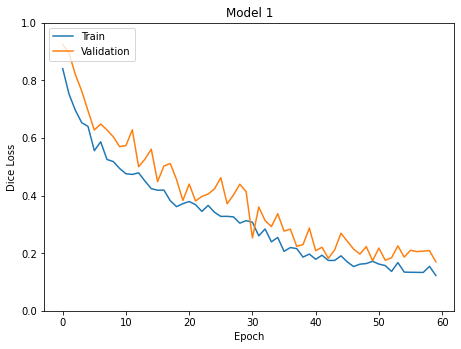

In [45]:
# print("-- Plotting the Graphs of Dice Loss on Training data --")
Loss_Graph(history)

## Evaluate

In [33]:
evaluate_model(model, testing_generator, verbose = 1)

-- Evaluating the model on the data --
38/38 [==============================] - 1376s 37s/step - loss: 0.3118 - dice_coef: 0.6882


# Ensembling

In [26]:
def ensemble_models(model, data_dir, weight_paths):
    pred_scores = []

    for record in os.listdir(data_dir):
        scores = []
        record_path = os.path.join(data_dir, record_path)
        volumes = [nib.load(os.path.join(record_path, path)).get_fdata() for path in enumerate(os.listdir(record_path)) if 'seg' not in path]
        data = np.expand_dims(np.concatenate(volumes, axis=-1), axis=0)

        for path in weight_paths:
            model.load_weights(path)
            scores.append(model.predict(data))
        scores = np.mean(scores, axis=0)
        pred_scores.append(scores)
        
    return scores

# Inference

In [27]:
result, score = inference(model, '00346')

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


## Visualize results

In [28]:
def load_prediction(ID):
    # load nifti file
    file_path = f'{ROOT_DIR}/predictions_1/s_{ID}.nii'
    nifti_file   = nib.load(file_path)

    # extracting data & converting to numpy file
    data_obj = np.asarray(nifti_file.dataobj)

    return data_obj

def load_data(ID, key):
    # load nifti file
    file_path = f'{ROOT_DIR}/data/BraTS2021_{ID}/BraTS2021_{ID}_{key}.nii'
    nifti_file   = nib.load(file_path)

    # extracting data & converting to numpy file
    data_obj = np.asarray(nifti_file.dataobj)

    return data_obj

In [29]:
def get_brain_data(ID):
  X_data = np.array([load_data(ID, key) for key in PARAMS['channel_keys']])
  y_true = load_data(ID, PARAMS['label_key'])
  y_pred = load_prediction(ID)

  X_data = np.moveaxis(X_data, 0, -1)
  X_data = np.moveaxis(X_data, 0, 1)
  y_true = np.moveaxis(y_true, 0, 1)
  y_pred = np.moveaxis(y_pred, 0, 1)

  y_true[y_true == 4] = 3
  y_pred[y_pred == 4] = 3
  
  return X_data, y_true, y_pred

In [30]:
X_data, y_true, y_pred = get_brain_data('00346')

labels of segmentation: [0 1 2 3]


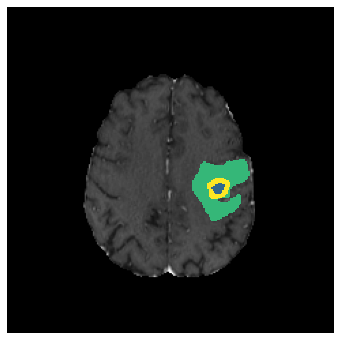

In [31]:
# Ground truth
plot_segment_map(X_data, y_true)

labels of segmentation: [0 1 2 3]


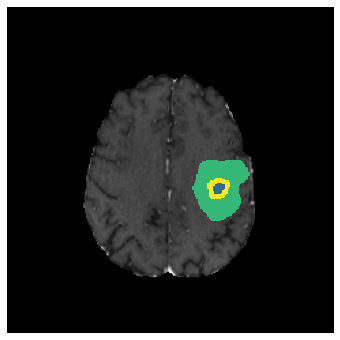

In [32]:
# Prediction
plot_segment_map(X_data, y_pred)

## Scores

In [ ]:
def change_mask_format(label_data):
  '''
   "enhancing tumor" (ET), the "tumor core" (TC=ET+NCR), and the "whole tumor" (WT=TC+ED).
    1 = NCR
    2 = ED (largest)
    4 = ET (smallest)
    0 = everything else
  '''
  label_data[label_data==4] = 3
  onehot_data = keras.utils.to_categorical(label_data, num_classes=PARAMS['n_classes'])
  ncr = onehot_data[:, :, :, 1]
  ed = onehot_data[:, :, :, 2]

  et = onehot_data[:, :, :, 3]
  tc = et+ncr
  wt = tc+ed
  return et, tc, wt

In [ ]:
et_pred, tc_pred, wt_pred = change_mask_format(y_pred)
et_true, tc_true, wt_true = change_mask_format(y_true)

In [ ]:
dice_coef_direct(tc_pred, tc_true)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9527085>

In [ ]:
hausdorff_distance(tc_pred, tc_true)

25.495097567963924